# Mnist手写数字识别神经网络
多分类

### 导入数据集

dict_keys(['image', 'label'])
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x1EA80D7D730>
5


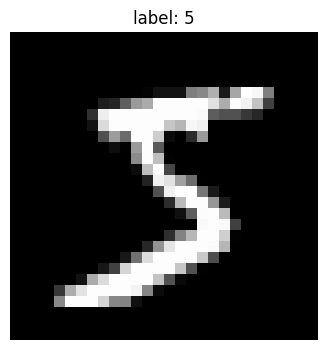

In [124]:
from random import sample
from datasets import load_from_disk
import matplotlib.pyplot as plt

dataset  = load_from_disk("D:/AILearn/Deep learning network/node/data/mnist")

train_data = dataset["train"]
test_data = dataset["test"]
sample = train_data[0]
print(sample.keys())
print(sample["image"])
print(sample["label"])

plt.figure(figsize=(4, 4))
plt.imshow(sample["image"],cmap="gray")  # 使用灰度色彩映射
plt.title(f'label: {sample["label"]}')
plt.axis('off')  # 不显示坐标轴
plt.show()


### 确定网络结构以及形状
隐藏层参数 W(784,64) b(1,64)
输出层参数 W(64,10) b(1,10)
softmax -> 概率值  
### 流程
1. 获取数据
2. 前向传播：网格结构定义
3. 损失计算
4. 反向传播 梯度下降优化
功能性模块：
· 准确率计算
· Tensorboard可视化
·  训练模型保存 加载 预测

In [125]:
import torch
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def transform_example(example):
    example['image'] = torchvision.transforms.ToTensor()(example['image'])
    example['image'] = torchvision.transforms.Normalize(mean=[0.5], std = [0.5])(example['image'])
    example['label'] = torch.tensor(example['label'], dtype=torch.int64)
    return example

train = train_data.map(transform_example)
test = test_data.map(transform_example)

train.set_format(type='torch')
test.set_format(type='torch')

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)#minibatch实现
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [126]:
class DeepNN(torch.nn.Module):
    def __init__(self,input_size = 784,hidden_size = [128,64],output_size = 10):
        super(DeepNN,self).__init__()
        self.fc1 = torch.nn.Linear(input_size,hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0],hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1],output_size)
        self.dropout = torch.nn.Dropout(0.2)#随机丢弃20%的神经元，防止过拟合
    
    def forward(self,x):
        x = x.view(-1,784) #将输入数据展平为一维向量
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [127]:
from torch import nn
import tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/mnist_experiment")

model = DeepNN().to(device)
criterion = nn.CrossEntropyLoss() #内含 softmax 交叉熵损失函数
optimizer_Adam = torch.optim.Adam(model.parameters(),lr=0.01) #随机梯度下降优化器
epoches = 1#训练轮数




def train(model,train_loader,criterion,optimizer,epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data["image"].to(device), data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() #封装了梯度计算
            optimizer.step() #根据梯度更新参数

            running_loss += loss.item()
            if i % 100 == 99:    # 每100个batch打印一次
                #print(model.fc1.weight.grad)  # 查看第一个全连接层权重的梯度
                #print(model.fc1.bias.grad)    # 查看第一个全连接层偏置的梯度
                avg_loss = running_loss / 100
                writer.add_scalar("train_loss", avg_loss, epoch * len(train_loader) + i)

                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, avg_loss))  
                running_loss = 0.0
    writer.close()
    print('Finished Training')
    return model

In [ ]:
#正确的手写动量梯度下降优化器
class MomentumSGD(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.9):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if momentum < 0.0:
            raise ValueError(f"Invalid momentum value: {momentum}")
        defaults = dict(lr=lr, momentum=momentum)
        super(MomentumSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        
        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                
                # 获取梯度
                d_p = p.grad.data
                
                # 初始化动量缓冲区
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.clone(d_p).detach() #分离梯度 避免跟踪
                else:
                    buf = param_state['momentum_buffer']
                    buf.mul_(momentum).add_(d_p)  # 正确的动量更新公式
                
                # (3) 更新参数 W_t
                # 执行公式2：W_t = W_{t-1} - lr * v_t
                # p.data.add_() 是一个 in-place 操作，相当于 p.data = p.data + (第一个参数 * 第二个参数)
                # 所以 p.data.add_(-lr, buf)  等价于 p.data = p.data + (-lr * buf)
                # 也就是 p.data = p.data - lr * buf
                p.data.add_(-lr, buf)
        
        return loss    

optimizer_SGD = MomentumSGD(model.parameters(), lr=0.001, momentum=0.9) 

dict_keys(['image', 'label'])
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x1EA80DA07D0>
5


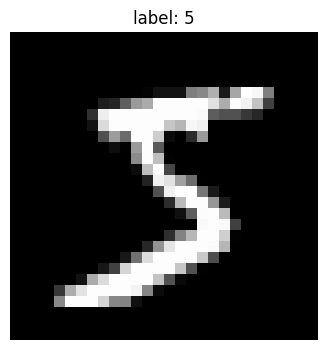

In [129]:
from random import sample
from datasets import load_from_disk
import matplotlib.pyplot as plt

dataset  = load_from_disk("D:/AILearn/Deep learning network/node/data/mnist")

train_data = dataset["train"]
test_data = dataset["test"]
sample = train_data[0]
print(sample.keys())
print(sample["image"])
print(sample["label"])

plt.figure(figsize=(4, 4))
plt.imshow(sample["image"],cmap="gray")  # 使用灰度色彩映射
plt.title(f'label: {sample["label"]}')
plt.axis('off')  # 不显示坐标轴
plt.show()


In [130]:
def test(model,test_loader):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    writer.add_scalar('Accuracy/test', accuracy, epoches)
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


In [131]:
train_model = train(model,train_loader,criterion,optimizer_SGD,epoches)

save_path = "D:/AILearn/Deep learning network/saved_model/mnist_model.pth"

test(model,test_loader)
torch.save(model.state_dict(),save_path)

[1,   100] loss: 2.261
[1,   200] loss: 2.085
[1,   300] loss: 1.726
[1,   400] loss: 1.301
[1,   500] loss: 1.030
[1,   600] loss: 0.846
[1,   700] loss: 0.804
[1,   800] loss: 0.712
[1,   900] loss: 0.662
[1,  1000] loss: 0.634
[1,  1100] loss: 0.581
[1,  1200] loss: 0.569
[1,  1300] loss: 0.556
[1,  1400] loss: 0.555
[1,  1500] loss: 0.497
[1,  1600] loss: 0.506
[1,  1700] loss: 0.486
[1,  1800] loss: 0.463
Finished Training
Accuracy of the network on the 10000 test images: 90 %
